In [1]:
import torch
import torch.nn as nn
import numpy as np
torch.set_printoptions(precision=12)

In [2]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import os
from skimage import io, transform
import torch.nn.functional as F
import math
import cv2

class ImageDataset(Dataset):

    def __init__(self, depthmap_dir, mask_dir, segmentation_dir, transform=None):
        """
        Args:
            depthmap_dir (string): Directory with all the depthmaps.
            mask_dir (string): Directory with all the masks.
            segmentation_dir (string): Directory with all the segmentation of the depthmaps.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.depthmap_dir = depthmap_dir
        self.mask_dir = mask_dir
        self.segmentation_dir = segmentation_dir
        self.transform = transform

    def __len__(self):
        path, dirs, files = next(os.walk(self.depthmap_dir))
        file_count = len(files)
        return file_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path_d, dirs_d, files_d = next(os.walk(self.depthmap_dir))
        img_d_name = os.path.join(self.depthmap_dir, files_d[idx])
        image_d = io.imread(img_d_name)
        
        path_m, dirs_m, files_m = next(os.walk(self.mask_dir))
        img_m_name = os.path.join(self.mask_dir, files_m[idx])
        image_m = io.imread(img_m_name)
        
        path_s, dirs_s, files_s = next(os.walk(self.segmentation_dir))
        img_s_name = os.path.join(self.segmentation_dir, files_s[idx])
        image_s = io.imread(img_s_name)

        if self.transform:
            image_d = self.transform(image_d)
            image_m = self.transform(image_m)
            image_s = self.transform(image_s)

        return image_d, image_m, image_s


class RandomCrop(object):
    """Crop randomly the image

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        if h!= new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top = 0
        if w!= new_w:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0
     
        image = image[top: top + new_h,
                      left: left + new_w]
        
        image = np.expand_dims(image, axis=2)

        return image
    
    
class Downsample(object):
    """Downsample the image

    Args:
        downsampling_factor (int or tuple): Desired downsampling factor for rows and columns.
        If the downsampling factor is an int, then both rows and columns are sampled by the same factor
    """

    def __init__(self, downsampling_factor):
        assert isinstance(downsampling_factor, (int, tuple))
        if isinstance(downsampling_factor, int):
            self.downsampling_factor = (downsampling_factor, downsampling_factor)
        else:
            assert len(downsampling_factor) == 2
            self.downsampling_factor = downsampling_factor

    def __call__(self, image):
        
        down_fact_h, down_fact_w = self.downsampling_factor
        image = image[::down_fact_h,
                      ::down_fact_w]

        return image
    
    
class ConvertDepthToColor(object):
    """ convert a 1xmxn 16-bits depthmap to a 2xmxn 8-bits colormap

    """

    def __call__(self, image):
        if len(image.shape[:]) <3:
            image = np.expand_dims(image, axis=2)
            
        h, w = image.shape[:2]
        image_r_color= np.zeros((h,w,1), dtype=int)
        image_g_color= np.zeros((h,w,1), dtype=int)
        image_g_color[(image > 2**8 - 1)] = image[(image > 2**8 - 1)] >> 8
        image_r_color = image - (image_g_color <<8)

        return np.concatenate((image_r_color, image_g_color), axis=2)
    

class ToTensor(object):
    """Convert ndarrays in images to Tensors."""

    def __call__(self, images):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        images = images.transpose((2, 0, 1))
        images = images.astype(float)
        return torch.from_numpy(images)
    

    
class ConvertColorToDepth(object):
    """ convert a 2xmxn 8-bits colormap to a 1xmxn 16-bits depthmap

    """

    def __call__(self, color_image):
            
        depth_image = color_image[:, 0, :, :]
        depth_image += color_image[:, 1, :, :] << 8

        return depth_image

    
def show_image_batch(images_batch):
    """Show image for a batch of samples."""
    if images_batch.size(1) == 1:
        images_batch_normed = images_batch/torch.max(images_batch)
        grid = utils.make_grid(images_batch_normed)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

        plt.title('Batch from dataloader')
    else:
        print(images_batch.size())
        images_b_batch = torch.zeros(images_batch.size(0), 1, images_batch.size(2) , images_batch.size(3))
        images_color_batch = torch.cat((images_batch, images_b_batch), 1) 
        print(images_color_batch.size())
        grid = utils.make_grid(images_color_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

        plt.title('Batch from dataloader')


        
def standardize_input(x):
    mean_channels = torch.mean(1.0*x, [2,3])
    mean_channels_images = (mean_channels.repeat_interleave(x.size()[2]*x.size()[3])).view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
    x_centered = x - mean_channels_images
    var = torch.sum(x_centered**2, (2, 3))/(x.size()[2]*x.size()[3])
    x_standardized = x_centered / torch.sqrt(var.view(x_centered.size()[0], x_centered.size()[1], 1, 1))
    return x_standardized, mean_channels, var




class MyConv(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.Tensor(self.out_channels, 1, self.n_channels, self.kernel_size_number)).cuda()
        self.bias = nn.Parameter(torch.Tensor(self.out_channels, 1)).cuda()
        
        
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    
    def forward(self, x):
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        result_seg = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        
        
        windows_depth = self.calculateWindows(x)
        windows_depth_seg = windows_depth
        
        
        # compute result
        #ponderation = torch.sum(windows_seg, (2,3))
        #ponderation = torch.sqrt(torch.sum(self.weight**2, (2,3))).view(self.weight.size()[0], self.weight.size()[1], 1, 1)
        #ponderation = self.kernel_size_number * self.n_channels 
        #ponderation = torch.sqrt(torch.sum(self.weight**2, (2,3))).view(self.weight.size()[0], self.weight.size()[1], 1, 1)
        #ponderation = 1
        print("weights size : ", self.weight.size())
        #print("ponderation size : ", ponderation.size())
        #print("weights without param: ", self.weight/ponderation)
        #self.weight = torch.nn.Parameter(self.weight/ponderation)
        print("weights param: ", self.weight)
        
        """
        for i in range(self.out_channels):
            print("sum weights : ",  torch.sum(torch.abs(weights_n[i, :,:,:,]), (2,3)))
        """
        result = torch.sum(windows_depth_seg * self.weight/ponderation , (2, 3)) + self.bias
        result = result.reshape(self.out_channels, x.shape[0], width, height)
        result = (result.transpose(0, 1))

        return result 
        
    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(1, -1, x.shape[1], self.kernel_size_number)
        #windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1

    
"""
class MyConvWithSeg(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConvWithSeg, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.Tensor(self.out_channels, 1, self.n_channels, self.kernel_size_number)).cuda()
        self.bias = nn.Parameter(torch.Tensor(self.out_channels, 1)).cuda()
        
        
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    
    def forward(self, x, seg):
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        result_seg = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        min_over_seg = torch.amin(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        max_over_seg = torch.amax(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        
        seg = (seg - min_over_seg)/(max_over_seg - min_over_seg)
        windows_depth = self.calculateWindows(x)
        windows_seg = self.calculateWindows(seg)
        windows_seg_cp =  windows_seg.clone()
        print("windows seg size : ", windows_seg.size())
        windows_seg[windows_seg < 1] = -1
        windows_seg_centers = windows_seg[0, :, :, windows_seg.size()[3]//2].view(1, windows_seg.size()[1], windows_seg.size()[2], 1)
        windows_seg = windows_seg * windows_seg_centers
        windows_seg[windows_seg < 1] = 0 
        windows_depth_seg = windows_depth * windows_seg
        
        # compute result
        ponderation = torch.sqrt(torch.sum(self.weight**2, (2,3))).view(self.weight.size()[0], self.weight.size()[1], 1, 1)
        #print("weights size : ", self.weight.size())
        #print("ponderation size : ", ponderation.size())
        weight_n = self.weight/ponderation
        
        result = torch.sum(windows_depth_seg * weight_n , (2, 3)) + self.bias
        result = result.reshape(self.out_channels, x.shape[0], width, height)
        result = (result.transpose(0, 1))
        
        
        # compute result_seg
        windows_seg_seg = windows_seg_cp * windows_seg
        print("windows_seg_seg max, : ", torch.max(windows_seg_seg))
        print("windows_seg_seg min, : ", torch.min(windows_seg_seg))
        result_seg = result_seg.reshape(self.out_channels, seg.shape[0], width, height)
        result_seg = (result_seg.transpose(0, 1))
        thresh = (torch.max(result_seg) + torch.min(result_seg))/2.0
        #result_seg = (result_seg > thresh).float()
        

        return result
        
        
    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(1, -1, x.shape[1], self.kernel_size_number)
        #windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1

"""

class MyConvWithSeg(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConvWithSeg, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.Tensor(self.out_channels, 1, self.n_channels, self.kernel_size_number)).cuda()
        self.bias = nn.Parameter(torch.Tensor(self.out_channels, 1)).cuda()
        
        
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    
    def forward(self, x, seg):
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        result_seg = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        min_over_seg = torch.amin(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        max_over_seg = torch.amax(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        seg = (seg - min_over_seg)/(max_over_seg - min_over_seg)
        seg = (seg > 0.5).float()
        
        
        windows_depth = self.calculateWindows(x)
        windows_seg = self.calculateWindows(seg)
        windows_seg[windows_seg<1] = -1
        windows_seg_centers = windows_seg[0, :, :, windows_seg.size()[3]//2].view(1, windows_seg.size()[1], windows_seg.size()[2], 1)
        windows_seg = windows_seg * windows_seg_centers
        windows_seg[windows_seg<1] = 0
        windows_depth_seg = windows_depth * windows_seg
        windows_depth_seg = windows_depth
        
        # compute result
        #ponderation = torch.sqrt(torch.sum(self.weight**2, (2,3))).view(self.weight.size()[0], self.weight.size()[1], 1, 1)
        """
        print("weights size : ", self.weight.size())
        print("ponderation size : ", ponderation.size())
        """
        #weight_n = self.weight/ponderation
        """
        for i in range(self.out_channels):
            print("sum weights : ",  torch.sum(torch.abs(weights_n[i, :,:,:,]), (2,3)))
        """
        
        result = torch.sum(windows_depth_seg * self.weight , (2, 3)) + self.bias
        result = result.reshape(self.out_channels, x.shape[0], width, height)
        result = (result.transpose(0, 1))

        
        
        # compute result_seg
        windows_seg_seg = self.calculateWindows(seg) * windows_seg
        result_seg = torch.sum(windows_seg_seg *  self.weight, (2, 3)) + self.bias
        result_seg = result_seg.reshape(self.out_channels, x.shape[0], width, height)
        result_seg = (result_seg.transpose(0, 1))
        
        return result, result_seg

        
    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(1, -1, x.shape[1], self.kernel_size_number)
        #windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1    
        
    
    
    
    
class MyConv2d_par(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d_par, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.Tensor(self.out_channels, 1, self.n_channels, self.kernel_size_number))
        #self.weight.data.uniform_(0, 1)
        self.bias = nn.Parameter(torch.Tensor(self.out_channels, 1))
        #self.bias.data.uniform_(0, 1)
        
        
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    
    def forward(self, x): #, x_segmented):
        if x.is_cuda:
            self.weight = self.weight.cuda()
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        result_seg = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        
        
        windows_depth = self.calculateWindows(x)
        
        windows_seg = self.calculateWindows(x_segmented)
        windows_seg[windows_seg < 1] = -1
        windows_seg_centers = windows_seg[0, :, :, windows_seg.size()[3]//2].view(1, windows_seg.size()[1], windows_seg.size()[2], 1)
        windows_seg = windows_seg * windows_seg_centers
        windows_seg[windows_seg < 1] = 0 
        windows_depth_seg = windows_depth * windows_seg
        
        windows_depth_seg = windows_depth
        
        
        # compute result
        #ponderation = torch.sum(windows_seg, (2,3))
        #ponderation = torch.sqrt(torch.sum(self.weight**2, (2,3))).view(self.weight.size()[0], self.weight.size()[1], 1, 1)
        ponderation = torch.sum(torch.abs(self.weight), (2,3)).view(self.weight.size()[0], self.weight.size()[1], 1, 1)
        print("weights size : ", self.weight.size())
        print("ponderation size : ", ponderation.size())
        #ponderation = self.kernel_size_number * self.n_channels 
        self.weight = self.weight/ponderation
        """
        for i in range(self.out_channels):
            print("sum weights : ",  torch.sum(torch.abs(weights_n[i, :,:,:,]), (2,3)))
        """
        result = torch.sum(windows_depth_seg * self.weight , (2, 3)) + self.bias
        #result = (result.transpose(0, 1)).reshape(x.shape[0], self.out_channels, width, height)
        result = result.reshape(self.out_channels, x.shape[0], width, height)
        result = (result.transpose(0, 1))
        
        # compute result_seg
        windows_seg_seg = self.calculateWindows(x_segmented) * windows_seg
        #result_seg = (result_seg.transpose(0, 1)).reshape(x_segmented.shape[0], self.out_channels, width, height)
        result_seg = result_seg.reshape(self.out_channels, x_segmented.shape[0], width, height)
        result_seg = (result_seg.transpose(0, 1))
        #result_seg = torch.clamp(result_seg, min=0, max=1)
        thresh = (torch.max(result_seg) + torch.min(result_seg))/2.0
        result_seg = (result_seg > thresh).int()


        return result, result_seg
        
    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(1, -1, x.shape[1], self.kernel_size_number)
        #windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1

    
    
    
class MyConv2d_test(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d_test, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weight = nn.Parameter(torch.Tensor(self.out_channels, 1, self.n_channels, self.kernel_size_number))
        #self.weight.data.uniform_(0, 1)
        self.bias = nn.Parameter(torch.Tensor(self.out_channels, 1))
        #self.bias.data.uniform_(0, 1)
        
        
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    
    def forward(self, x):
        if x.is_cuda:
            self.weight = self.weight.cuda()
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        result_seg = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )
        
        
        windows_depth = self.calculateWindows(x)
        
        
        # compute result
        ponderation = self.kernel_size_number
        result = torch.sum(windows_depth * self.weight , (2, 3))/ponderation + self.bias
        #result = (result.transpose(0, 1)).reshape(x.shape[0], self.out_channels, width, height)
        result = result.reshape(x.shape[0], self.out_channels, width, height)

        return result
        
    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(1, -1, x.shape[1], self.kernel_size_number)
        #windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1
    
    
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device




In [3]:
#define the model

class stackedCustomConv(nn.Module):
    def __init__(self):
        super(stackedCustomConv, self).__init__()
       
        self.conv1 = MyConvWithSeg(1, 2, 5, stride=1, padding=2)  
        self.conv2 = MyConvWithSeg(2, 3, 5, stride=1, padding=2)
    
        
    def forward(self, x, seg):
        min_over_seg = torch.amin(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        max_over_seg = torch.amax(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        seg =  (seg - min_over_seg)/(max_over_seg - min_over_seg)
        seg = (seg > -0.1).float()
        x1, seg = self.conv1(x, seg)
        min_over_seg = torch.amin(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        max_over_seg = torch.amax(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        seg =  (seg - min_over_seg)/(max_over_seg - min_over_seg)
        seg = (seg > -0.1).float()
        seg1 = seg.clone()
        #x = F.relu(x)
        x2, seg = self.conv2(x1, seg)
        #x = F.relu(x)
        min_over_seg = torch.amin(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        max_over_seg = torch.amax(seg, dim=(1, 2, 3)).view(seg.size()[0], 1, 1, 1)
        seg =  (seg - min_over_seg)/(max_over_seg - min_over_seg)
        seg = (seg > -0.1).float()
        seg2 = seg.clone()
        
        return x1, x2, seg1, seg2


class stackedPyConv(nn.Module):
    def __init__(self):
        super(stackedPyConv, self).__init__()
       
        self.conv1 = nn.Conv2d(1, 2, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(2, 3, 5, stride=1, padding=2)
    
        
    def forward(self, x):
        x = self.conv1(x)
        #x = F.relu(x)
        x = self.conv2(x)
        #x = F.relu(x)
        return x 

In [4]:
device = get_device()

test_dataset = ImageDataset(depthmap_dir='D:/autoencoder_data/depthmaps/test/dilated', 
                                mask_dir='D:/autoencoder_data/depthmaps/test/mask',
                                segmentation_dir='D:/autoencoder_data/depthmaps/test/segmentation_roipoly',
                                transform=transforms.Compose([RandomCrop((480, 640)), ToTensor()])
                                 )

test_image = torch.cat((test_dataset[0][0].unsqueeze(0).float(), test_dataset[1][0].unsqueeze(0).float(), test_dataset[2][0].unsqueeze(0).float()),0)
print("test image size : ", test_image.size())
test_mask = torch.cat((test_dataset[0][1].unsqueeze(0).float(), test_dataset[1][1].unsqueeze(0).float(), test_dataset[2][1].unsqueeze(0).float()), 0)
test_seg = torch.cat((test_dataset[0][2].unsqueeze(0).float(), test_dataset[1][2].unsqueeze(0).float(), test_dataset[2][2].unsqueeze(0).float()), 0)

custom_model = MyConvWithSeg(1, 5, 5, stride=1, padding=2)
filtered_image = custom_model(test_image, test_seg)


test image size :  torch.Size([3, 1, 480, 640])
windows seg size :  torch.Size([1, 921600, 1, 25])
windows seg centers size :  torch.Size([1, 921600, 1, 1])
weights size :  torch.Size([5, 1, 1, 25])


test image size :  torch.Size([3, 1, 480, 640])
max standardized im :  tensor(3.422230243683, device='cuda:0')
min standardized im :  tensor(-1.465722799301, device='cuda:0')
filtered_image size :  torch.Size([3, 2, 480, 640])
max :  tensor(2.212354898453, device='cuda:0')
min :  tensor(-4.622655391693, device='cuda:0')
max :  tensor(1.912738084793, device='cuda:0')
min :  tensor(-3.835141897202, device='cuda:0')
max :  tensor(2.414782047272, device='cuda:0')
min :  tensor(-4.212890148163, device='cuda:0')
max :  tensor(3.056722164154, device='cuda:0')
min :  tensor(-1.654928922653, device='cuda:0')
max :  tensor(2.707487344742, device='cuda:0')
min :  tensor(-1.553974509239, device='cuda:0')
max :  tensor(2.822571277618, device='cuda:0')
min :  tensor(-1.808093547821, device='cuda:0')


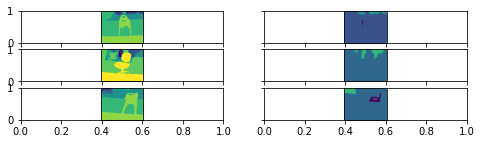

In [4]:
device = get_device()
test_dataset = ImageDataset(depthmap_dir='D:/autoencoder_data/depthmaps/test/dilated', 
                                mask_dir='D:/autoencoder_data/depthmaps/test/mask',
                                segmentation_dir='D:/autoencoder_data/depthmaps/test/segmentation_roipoly',
                                transform=transforms.Compose([RandomCrop((480, 640)), ToTensor()])
                                 )

test_image = torch.cat((test_dataset[0][0].unsqueeze(0).float(), test_dataset[1][0].unsqueeze(0).float(), test_dataset[2][0].unsqueeze(0).float()),0)
print("test image size : ", test_image.size())
test_mask = torch.cat((test_dataset[0][1].unsqueeze(0).float(), test_dataset[1][1].unsqueeze(0).float(), test_dataset[2][1].unsqueeze(0).float()), 0)
test_seg = torch.cat((test_dataset[0][2].unsqueeze(0).float(), test_dataset[1][2].unsqueeze(0).float(), test_dataset[2][2].unsqueeze(0).float()), 0)


[test_image_standardized, mean_channels, std_channels] = standardize_input(test_image.cuda())
print("max standardized im : ", torch.max(test_image_standardized))
print("min standardized im : ", torch.min(test_image_standardized))
custom_model = stackedCustomConv()
filtered_image1, filtered_image2, filtered_seg1, filtered_seg2 = custom_model(test_image_standardized, test_seg.cuda())
#filtered_image1 = custom_model(test_image_standardized, test_seg.cuda())

print("filtered_image size : ", filtered_image1.size())

size_batch = test_image.size()[0]
out_channel = 2

fig, axes = plt.subplots(nrows=size_batch, ncols=out_channel, sharex=True, sharey=True, figsize=(8, 2))
with torch.no_grad():
    for i in range(out_channel):
        for j in range(size_batch):
            ax = fig.add_subplot(size_batch, out_channel, i+1 + j*out_channel, xticks=[], yticks=[])
            plt.imshow((torch.squeeze(filtered_image1[j, i, :, :])).int().cpu())
            #cv2.imwrite("D:\\autoencoder_data\\test\\" + "img" + str(i)+".png", (torch.squeeze(filtered_image)[i, :, :]).int().cpu().numpy().astype(np.uint16))

            # make 8-bit image
            im_max = torch.max((torch.squeeze(filtered_image1[j, i, :, :])))
            print("max : ", im_max)
            im_min = torch.min((torch.squeeze(filtered_image1[j, i, :, :])))
            print("min : ", im_min)
            image_8b = (( (torch.squeeze(filtered_image1[j, i, :, :])) - im_min)/(im_max - im_min)*255).int()
            cv2.imwrite("D:\\autoencoder_data\\test\\me\\" + "1_img" + str(j)+ "_"+  str(i)+ ".png", (image_8b.cpu().numpy().astype(np.uint8)))




max :  tensor(1.635018467903, device='cuda:0')
min :  tensor(-3.289807081223, device='cuda:0')
max :  tensor(1.477177619934, device='cuda:0')
min :  tensor(-2.865291118622, device='cuda:0')
max :  tensor(1.869428396225, device='cuda:0')
min :  tensor(-3.079911947250, device='cuda:0')
max :  tensor(2.528166294098, device='cuda:0')
min :  tensor(-1.472085356712, device='cuda:0')
max :  tensor(2.013394117355, device='cuda:0')
min :  tensor(-1.884252667427, device='cuda:0')
max :  tensor(2.305056810379, device='cuda:0')
min :  tensor(-1.536331892014, device='cuda:0')
max :  tensor(0.979720890522, device='cuda:0')
min :  tensor(-1.665097355843, device='cuda:0')
max :  tensor(0.993758976460, device='cuda:0')
min :  tensor(-1.638522863388, device='cuda:0')
max :  tensor(0.999725759029, device='cuda:0')
min :  tensor(-2.244165658951, device='cuda:0')


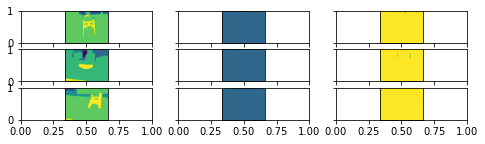

In [5]:
size_batch = test_image.size()[0]
out_channel = 3

fig, axes = plt.subplots(nrows=size_batch, ncols=out_channel, sharex=True, sharey=True, figsize=(8, 2))
with torch.no_grad():
    for i in range(out_channel):
        for j in range(size_batch):
            ax = fig.add_subplot(size_batch, out_channel, i+1 + j*out_channel, xticks=[], yticks=[])
            plt.imshow((torch.squeeze(filtered_image2[j, i, :, :])).int().cpu())
            #cv2.imwrite("D:\\autoencoder_data\\test\\" + "img" + str(i)+".png", (torch.squeeze(filtered_image)[i, :, :]).int().cpu().numpy().astype(np.uint16))

            # make 8-bit image
            im_max = torch.max((torch.squeeze(filtered_image2[j, i, :, :])))
            print("max : ", im_max)
            im_min = torch.min((torch.squeeze(filtered_image2[j, i, :, :])))
            print("min : ", im_min)
            image_8b = (( (torch.squeeze(filtered_image2[j, i, :, :])) - im_min)/(im_max - im_min)*255).int()
            cv2.imwrite("D:\\autoencoder_data\\test\\me\\" + "2_img" + str(j)+ "_"+  str(i)+ ".png", (image_8b.cpu().numpy().astype(np.uint8)))


max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')


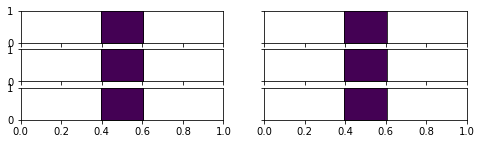

In [6]:
size_batch = test_seg.size()[0]
out_channel = 2

fig, axes = plt.subplots(nrows=size_batch, ncols=out_channel, sharex=True, sharey=True, figsize=(8, 2))
with torch.no_grad():
    for i in range(out_channel):
        for j in range(size_batch):
            ax = fig.add_subplot(size_batch, out_channel, i+1 + j*out_channel, xticks=[], yticks=[])
            plt.imshow((torch.squeeze(filtered_seg1[j, i, :, :])).int().cpu())
            #cv2.imwrite("D:\\autoencoder_data\\test\\" + "img" + str(i)+".png", (torch.squeeze(filtered_image)[i, :, :]).int().cpu().numpy().astype(np.uint16))

            # make 8-bit image
            im_max = torch.max((torch.squeeze(filtered_seg1[j, i, :, :])))
            print("max : ", im_max)
            im_min = torch.min((torch.squeeze(filtered_seg1[j, i, :, :])))
            print("min : ", im_min)
            image_8b = (( (torch.squeeze(filtered_seg1[j, i, :, :])) - im_min)/(im_max - im_min)*255).int()
            cv2.imwrite("D:\\autoencoder_data\\test\\me\\" + "1_seg" + str(j)+ "_"+  str(i)+ ".png", (image_8b.cpu().numpy().astype(np.uint8)))



max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')
max :  tensor(1., device='cuda:0')
min :  tensor(1., device='cuda:0')


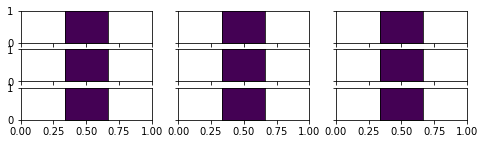

In [7]:
size_batch = test_seg.size()[0]
out_channel = 3

fig, axes = plt.subplots(nrows=size_batch, ncols=out_channel, sharex=True, sharey=True, figsize=(8, 2))
with torch.no_grad():
    for i in range(out_channel):
        for j in range(size_batch):
            ax = fig.add_subplot(size_batch, out_channel, i+1 + j*out_channel, xticks=[], yticks=[])
            plt.imshow((torch.squeeze(filtered_seg2[j, i, :, :])).int().cpu())
            #cv2.imwrite("D:\\autoencoder_data\\test\\" + "img" + str(i)+".png", (torch.squeeze(filtered_image)[i, :, :]).int().cpu().numpy().astype(np.uint16))

            # make 8-bit image
            im_max = torch.max((torch.squeeze(filtered_seg2[j, i, :, :])))
            print("max : ", im_max)
            im_min = torch.min((torch.squeeze(filtered_seg2[j, i, :, :])))
            print("min : ", im_min)
            image_8b = (( (torch.squeeze(filtered_seg2[j, i, :, :])) - im_min)/(im_max - im_min)*255).int()
            cv2.imwrite("D:\\autoencoder_data\\test\\me\\" + "2_seg" + str(j)+ "_"+  str(i)+ ".png", (image_8b.cpu().numpy().astype(np.uint8)))



max :  tensor(1.635018706322, device='cuda:0')
min :  tensor(-3.289806842804, device='cuda:0')
max :  tensor(1.477177739143, device='cuda:0')
min :  tensor(-2.865290880203, device='cuda:0')
max :  tensor(1.869428753853, device='cuda:0')
min :  tensor(-3.079911708832, device='cuda:0')
max :  tensor(2.528166532516, device='cuda:0')
min :  tensor(-1.472084999084, device='cuda:0')
max :  tensor(2.013393878937, device='cuda:0')
min :  tensor(-1.884253144264, device='cuda:0')
max :  tensor(2.305056571960, device='cuda:0')
min :  tensor(-1.536331534386, device='cuda:0')
max :  tensor(0.979720890522, device='cuda:0')
min :  tensor(-1.665097832680, device='cuda:0')
max :  tensor(0.993758976460, device='cuda:0')
min :  tensor(-1.638522624969, device='cuda:0')
max :  tensor(0.999725639820, device='cuda:0')
min :  tensor(-2.244165658951, device='cuda:0')


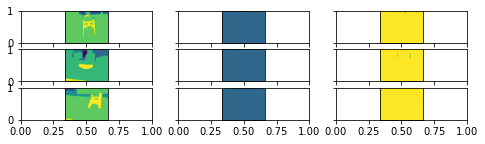

In [8]:
pytorch_model = stackedPyConv()

pytorch_model.conv1.weight = nn.Parameter((custom_model.conv1.weight).view(2, 1, 5, 5))
pytorch_model.conv1.bias = nn.Parameter(torch.squeeze((custom_model.conv1.bias)))
pytorch_model.conv2.weight = nn.Parameter((custom_model.conv2.weight).view(3, 2, 5, 5))
pytorch_model.conv2.bias = nn.Parameter(torch.squeeze((custom_model.conv2.bias)))

filtered_image = pytorch_model(test_image_standardized)


size_batch = test_image.size()[0]
out_channel = 3

fig, axes = plt.subplots(nrows=size_batch, ncols=out_channel, sharex=True, sharey=True, figsize=(8, 2))
with torch.no_grad():
    for i in range(out_channel):
        for j in range(size_batch):
            ax = fig.add_subplot(size_batch, out_channel, i+1 + j*out_channel, xticks=[], yticks=[])
            plt.imshow((torch.squeeze(filtered_image[j, i, :, :])).int().cpu())
            #cv2.imwrite("D:\\autoencoder_data\\test\\" + "img" + str(i)+".png", (torch.squeeze(filtered_image)[i, :, :]).int().cpu().numpy().astype(np.uint16))

            # make 8-bit image
            im_max = torch.max((torch.squeeze(filtered_image[j, i, :, :])))
            print("max : ", im_max)
            im_min = torch.min((torch.squeeze(filtered_image[j, i, :, :])))
            print("min : ", im_min)
            image_8b = (( (torch.squeeze(filtered_image[j, i, :, :])) - im_min)/(im_max - im_min)*255).int()
            cv2.imwrite("D:\\autoencoder_data\\test\\py\\" + "img" + str(j)+ "_"+  str(i)+ ".png", (image_8b.cpu().numpy().astype(np.uint8)))

In [6]:
conv1 = nn.Conv2d(in_channels, out_channels, size_filter, stride=1, padding=1)
conv2 = nn.Conv2d(out_channels, out_channels, size_filter, stride=1, padding=1)

print("conv weigths size : ", conv.weight.size())
print("conv1 weigths size : ", conv1.weight.size())
print("conv bias size : ", conv.bias.size())
print("conv1 bias size : ", conv1.bias.size())
conv1.weight = nn.Parameter((conv.weight).view(out_channels, in_channels, size_filter, size_filter))
conv1.bias = nn.Parameter(conv.bias.view(out_channels))
conv2.weight = nn.Parameter((conv_bis.weight).view(out_channels, out_channels, size_filter, size_filter))
conv2.bias = nn.Parameter(conv_bis.bias.view(out_channels))
[test_image_standardized, mean_channels, std_channels] = standardize_input(test_image)
print("images size : ", test_image_standardized.size())
filtered_image = conv1(test_image_standardized)
filtered_image_bis = conv2(filtered_image) 

fig, axes = plt.subplots(nrows=1, ncols=out_channels, sharex=True, sharey=True, figsize=(8, 2))
with torch.no_grad():            
    for i in range(out_channels):
        for j in range(size_batch):
            ax = fig.add_subplot(size_batch, out_channels, i+1 + out_channels*j, xticks=[], yticks=[])
            plt.imshow((torch.squeeze(filtered_image_bis[j, i, :, :])).int().cpu())
            # make 8-bit image
            im_max = torch.max((torch.squeeze(filtered_image_bis[j, i, :, :])))
            print("max : ", im_max)
            im_min = torch.min((torch.squeeze(filtered_image_bis[j, i, :, :])))
            print("min : ", im_min)
            image_8b = (( (torch.squeeze(filtered_image_bis[j, i, :, :])) - im_min)/(im_max - im_min)*255).int()
            cv2.imwrite("D:\\autoencoder_data\\test\\py\\" + "img" + str(j)+ "_"+ str(i) + ".png", (image_8b.cpu().numpy().astype(np.uint8)))
"""        
with torch.no_grad():
        filtered_image3 = (torch.squeeze(filtered_image)[2, :, :]).int().cpu().numpy()
        cv2.imwrite("C:\\Users\\root\\Desktop\\filtered_image3.png", filtered_image3.astype(np.uint16))
"""        

NameError: name 'in_channels' is not defined

True

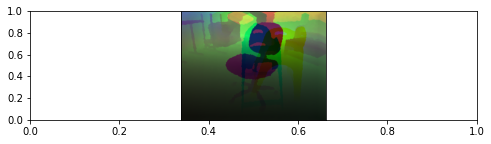

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(8, 2))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
test_image = ( (test_image - torch.min(test_image))/(torch.max(test_image) - torch.min(test_image))*255).int()
plt.imshow((torch.squeeze(test_image)).permute(1, 2, 0).cpu())

cv2.imwrite("D:\\autoencoder_data\\test\\" + "gt_img.png", ((torch.squeeze(test_image)).permute(1, 2, 0).cpu().numpy().astype(np.uint8)))